## Hyperplane folding.

The following code runs the algorithm from the paper:
*Hyperplane folding - a way to increase the margin in Support Vector Machines
*Lars Lundberg, Håkan Lennerstad, Eva Garcia-Martin, Niklas Lavesson and Veselka Boeva

It does the following:
1. Apply SVM in a dataset
2. Select the primary support vector
3. Divide the points into two, ones to the left of the support vector (forming an orthogonal line with the hyperplane) and the other ones to the right of the support vector
4. Apply two SVM on each new set of points
5. Rotate one side an angle a. 
6. The margin has thus increased from the initial one. 

In [29]:
"""
Simulation functions
"""

def generate_point(center, radius):
    #Generate a random vector on the unit circle (length 1)
    ang = uniform(0, 2*pi)
    v = np.array([cos(ang), sin(ang)])
 
    # Generate a normally distributed length
    #(mean = 0, so the length can be negative)
    l = radius + 1
    while abs(l) > radius:
        l = normalvariate(0, radius)
    return center + l * v


def generate_points(centers, points_per_circle, radius):
    X = list()
    Y = list()
    count = 1
    
    for center in centers:
        for i in range(points_per_circle):
            X.append(generate_point(center, radius))
            if count%2:
                Y.append(0)
            else:
                Y.append(1)
        count += 1
        
    X=np.array(X)
    Y=np.array(Y)
    return (X,Y)

def get_margin(clf):
    w = clf.coef_[0]
    a = -w[0] / w[1]
    s_vectors = clf.support_vectors_
    intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
    intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
    margin = (abs(intrc_up - intrc_down))/(math.sqrt(1+(a*a)))
    return margin

def plot_SVM_backup(clf,X,Y, should_plot):
    if should_plot: 
     
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
#         xx = np.linspace(X[:,0].min(),X[:,0].max())


        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])
        # plot support vectors
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', zorder=10, edgecolors='k')
        plt.show()

        
        
        
        
#         w = clf.coef_[0]
#         a = -w[0] / w[1]
#         xx = np.linspace(X[:,0].min(),X[:,0].max())
#         intercept = -(clf.intercept_[0]) / w[1]
#         s_vectors = clf.support_vectors_

#         # Margin
#         intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
#         intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
#         yy = a * xx + intercept
#         yy_up = a * xx + intrc_up
#         yy_down = a * xx + intrc_down
        
#         plt.plot(xx, yy, 'k-')
#         plt.plot(xx, yy_down, 'k--')
#         plt.plot(xx, yy_up, 'k--')

#         plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],s=80, facecolors='none')
#         plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
#         plt.axis('tight')
#         plt.show()
        
        
        
def plot_SVM(clf,X,Y, should_plot):
    if should_plot: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(X[:,0].min(),X[:,0].max())
        intercept = -(clf.intercept_[0]) / w[1]
        s_vectors = clf.support_vectors_

        # Margin
        intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
        intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
        yy = a * xx + intercept
        yy_up = a * xx + intrc_up
        yy_down = a * xx + intrc_down
        
        plt.plot(xx, yy, 'k-')
        plt.plot(xx, yy_down, 'k--')
        plt.plot(xx, yy_up, 'k--')

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],s=80, 
                    facecolors='none',zorder=10, edgecolors='k')
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
#         pdf.savefig(fig) # note the format='pdf' argument!
#         pdf.close()
    
def get_support_vector(X, Y, sv_index):
    """
    Return the prime support vector. sv_index: indices of the SVs
    We first calculate the sum. If the sum is 1, it means that there are 
    2 SVs in class 0, and 1 in class 1. Thus we need to choose the SV in class 1
    If the sum is 2, then we need to return the X where Y = 0. 
    """
#     print("Function: get support vector. SVs indixes: ", sv_index)
    s=0
    supp_v=0
    for i in sv_index:
        s += Y.iloc[i]
    for n in sv_index:
        if Y.iloc[n] == 1 and s == 1:
            return X.iloc[n]
        if Y.iloc[n] == 0 and s == 2:
            return X.iloc[n]
      
    raise Exception("Error in function get_support_vector. Values: s: " + str(s) + " SV index: " + str(sv_index) )
        

def point_vs_othline(point, prime_sv,  a): 
#     print("DEBUG point_vs_othline: point: ", point)
#     print("DEBUG : prime SV ", prime_sv, "a: ", a )
    
    t = (point[0] - prime_sv[0])/(-a)
    if (point[1]) <= (prime_sv[1] + t):
        return "higher/right"
    else:
        return "lower/left"
    
def splitting_backup(X,Y, clf, prime_sv):
    r"""
    Splitting the points in X and Y, based on an orthogonal line to the hyperplane
    obtained by the classifier clf
    
    return: both sets of points
    """
    set1x=list()
    set2x=list()
    set1y=list()
    set2y=list()
    # In case there are more than 1 point with the same value as the support vector, so that we don't add it twice.
    already_added = False
    

    if len(clf.support_vectors_) == 3: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        i=0
        for item in X:
            if (item[0]==prime_sv[0]) and (item[1]==prime_sv[1]) and already_added == False:
                set1x.append(item)
                set1y.append(Y[i])
                set2x.append(item)
                set2y.append(Y[i])
                already_added = True
            elif point_vs_othline(item,prime_sv,a ) == "higher/right":
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a) == "lower/left":
                set1x.append(item)
                set1y.append(Y[i])
            else:
                print("There is something wrong. Point is not either higher nor lower")
            i+=1
    else:
        raise Exception('More than 3 Support Vectors. N of SV: ', suppsum )
    return [set1x, set1y, set2x, set2y]

def splitting(X,Y,clf,prime_sv):
    r"""
    Splitting the points in X and Y, based on an orthogonal line to the hyperplane
    obtained by the classifier clf
    
    return: both sets of points, as DFs mantaining original index
    """
    index_set1 = list()
    index_set2 = list()
    already_added = False
    prime_sv_index = None

    if len(clf.support_vectors_) == 3: 
        # Indexes
        w = clf.coef_[0]
        a = -w[0] / w[1]
        i=0
#         print("prime_sv ", prime_sv)

        for item in np.array(X):
            if (item[0]==prime_sv[0]) and (item[1]==prime_sv[1]) and already_added == False:
                index_set1.append(i)
                index_set2.append(i)
                prime_sv_index = i
                already_added = True
            elif point_vs_othline(item,prime_sv,a ) == "higher/right":
                index_set2.append(i)
            elif point_vs_othline(item,prime_sv,a) == "lower/left":
                index_set1.append(i)
            else:
                print("Error in Splitting function. Point is not higher nor lower")
            i+=1
          
#         print("Indexes: Set1: ", index_set1, " Set2: ", index_set2)
#         print("prime_sv_index: ", prime_sv_index)

        # Get the DFs
        set1X = X.iloc[index_set1]
        set2X = X.iloc[index_set2]
        set1Y = Y.iloc[index_set1]
        set2Y = Y.iloc[index_set2]
    else:
        raise Exception('More than 3 Support Vectors. N of SV: ', suppsum )
    return [set1X, set2X, set1Y, set2Y, prime_sv_index]
        

def get_folding_point(clf1, clf2):
    
    w1 = clf1.coef_[0]
    a1 = -w1[0] / w1[1]
    intercept1= -(clf1.intercept_[0]) / w1[1]
    
    w2 = clf2.coef_[0]
    a2 = -w2[0] / w2[1]
    intercept2= -(clf2.intercept_[0]) / w2[1]
    
    xf = (intercept2-intercept1)/(a1-a2)
    yf = xf*a1 + intercept1
    
    angle = np.arctan(a1) - np.arctan(a2)
    return [xf,yf] , angle
    
def remove_supp (sx, sy, supp):
    
    index=0
    while sx[index][0] != supp[0] and sx[index][1] != supp[1]:
        index+=1
    sx = np.delete(sx,index, 0)
    sy = np.delete(sy,index)
    
    return sx,sy
    
     

def folding_set(X, f_point, angle):
    """
    1. Substract f_point
    2. Caclualte x_p, y_p. 
    3. sum f_point
    The idea was to apply a function to the whole dataframe, but we haven't yet done that optimized version
    """
    X_copy = X
    for i in range(0,len(X)):
        X_copy.iat[i,0] = X.iloc[i,0] - f_point[0]
        X_copy.iat[i,1] = X.iloc[i,1] - f_point[1]

        x_p = np.cos(angle)*X_copy.iloc[i,0] - np.sin(angle)*X_copy.iloc[i,1]
        y_p = np.sin(angle)*X_copy.iloc[i,0] + np.cos(angle)*X_copy.iloc[i,1]
        
        X_copy.iat[i,0] = x_p + f_point[0]
        X_copy.iat[i,1] = y_p + f_point[1]
    X = X_copy
    return X

   

def get_clf():
    """
    Return the classifier, so that we can test different classifiers and not only one
    We don't need to change the instance everywhere, which outputs many errors due to the manual
    change that it requires. 

    """
     
#     C = 1000000000
    return svm.SVC(kernel='linear', C=100000) 
#     return svm.NuSVC(kernel='linear', nu=0.0000001) 

def folding(X,Y,X_test,Y_test, clf, plot = True):
    """
    Gets the main support vector. 
    Divides the dataset into 2,based on the orthogonal line 
    to the plane and the main support vector. 
    Apply SVM on both sides, rotate the one with the greatest margin. 
    We need to remove the support vector, since it is repeated.
    Set1, Set2: DF with their respective class. 
    prime_sv_index: To remove it later when folding
    """
    # clf.support_ = indices of SVs
#     print("DEBUG: SVs 2 :\n", clf.support_vectors_)
    prime_sv = get_support_vector(X,Y, clf.support_)
    set1X, set2X, set1Y, set2Y, prime_sv_index = splitting(X, Y, clf, prime_sv)
    
    # Test
    set1X_test, set2X_test, set1Y_test, set2Y_test, prime_sv_index_test = splitting(X_test, Y_test, clf, prime_sv)

#     print("DEBUG: After splitting: ")
#     print("DEBUG: Set1X: ") 
#     display(set1X)
#     print("DEBUG: Set2X: ") 
#     display(set2X)
    clf_set1 = get_clf()
    clf_set1.fit(set1X, set1Y)
    margin1 = get_margin(clf_set1)
    
    clf_set2 = get_clf()
    clf_set2.fit(set2X, set2Y)
    margin2 = get_margin(clf_set2)
    
    f_point, angle = get_folding_point(clf_set1, clf_set2)
    
    if plot:
        print("\nSVM Set 1: LEFT")
        plot_SVM(clf_set1, np.array(set1X), np.array(set1Y),plot)
        print("\nSVM Set 2: RIGHT")
        plot_SVM(clf_set2, np.array(set2X), np.array(set2Y) ,plot)

    # Fold points . Add them to the DF using the same indexes as before
    if margin1 > margin2: 
        part_folded = "left"
        print("Folding SET1")
        # Remove the primeSV. It's the index repeated in both sets
        set1X = set1X.drop(prime_sv_index)
        set1Y = set1Y.drop(prime_sv_index)

        set1X_folded = folding_set(set1X, f_point, -angle)
        X_folded = pd.concat([set1X_folded,set2X]).sort_index(inplace=False)
        Y_folded = pd.concat([set1Y,set2Y]).sort_index(inplace=False)
        
        # Test
#         set1X_test = set1X_test.drop(prime_sv_index)
#         set1Y_test = set1Y_test.drop(prime_sv_index)

        set1X_folded_test = folding_set(set1X_test, f_point, -angle)
        X_folded_test = pd.concat([set1X_folded_test,set2X_test]).sort_index(inplace=False)
        Y_folded_test = pd.concat([set1Y_test,set2Y_test]).sort_index(inplace=False)
        
    else:
        part_folded = "right"
        print("Folding SET2")
        set2X = set2X.drop(prime_sv_index)
        set2Y = set2Y.drop(prime_sv_index)
        
        set2X_folded = folding_set(set2X, f_point, angle)
        X_folded = pd.concat([set2X_folded,set1X]).sort_index(inplace=False)
        Y_folded = pd.concat([set1Y,set2Y]).sort_index(inplace=False)
        
        #Test
#         set2X_test = set2X_test.drop(prime_sv_index)
#         set2Y_test = set2Y_test.drop(prime_sv_index)
        
        set2X_folded_test = folding_set(set2X_test, f_point, angle)
        X_folded_test = pd.concat([set2X_folded_test,set1X_test]).sort_index(inplace=False)
        Y_folded_test = pd.concat([set1Y_test,set2Y_test]).sort_index(inplace=False)

      
    #print ("DEBUG: After folding. \n X Folded: ")
#     display(X_folded)
#     print("Y Folded: ")
#     display(Y_folded)

    return part_folded, X_folded, Y_folded, X_folded_test, Y_folded_test

def plot_points(x,y, should_plot):
    if should_plot:
        pdf = PdfPages('points' + str(time.clock()) + '.pdf')
        
        fig=figure(figsize=(6,4))
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
        
def remove_extra_sv(clf, X,Y):
    """
    1. Remove the repeated SV
    2. We remove it from the X,Y sets, and create a new clf. 
    """
    clf.support_vectors_ = np.around(clf.support_vectors_, decimals=6)
#     X = dataset.iloc[:,:2]
    unique_SVs, ind_SVs = np.unique(clf.support_vectors_, axis=0, return_index = True)
#     print("DEBUG: SVs after removing duplicates")
#     print(unique_SVs)
#     print(ind_SVs)
    
#     ind_extra_el =list()
    tmp_set_ind = set(clf.support_[ind_SVs])
    ind_extra_SVs = [x for x in clf.support_ if x not in tmp_set_ind]
    
#     print("EXTRA SVs: index ",ind_extra_SVs )
#     print("EXTRA SVs: SVs \n", X.iloc[ind_extra_SVs] )
    if ind_extra_SVs: # List not empty
        X_tmp = X.drop(ind_extra_SVs)
        Y_tmp = Y.drop(ind_extra_SVs)
        clf = get_clf() 
        clf.fit(X_tmp, Y_tmp)
        
  
        # We return the original information
        
#     if len(unique_SVs)>3:
#         print("%% Remove extra SV. In progress %%")
#     else:
#         clf.support_vectors_ = unique_SVs
#         clf.support_ = clf.support_[ind_SVs]
#         clf.dual_coef_ = clf.dual_coef_[0,ind_SVs]
#         clf.dual_coef_ = clf.dual_coef_.reshape((1,-1))
    

#     SV0 = clf.support_vectors_[dataset['class'][clf.support_]==0]
#     SV1 = clf.support_vectors_[dataset['class'][clf.support_]==1]
#     clf.support_vectors_ = SV0[0:2]+SV1[0:1]
#     clf.support

    
    return clf

def get_accuracy(training, test):
    """ 
    Testing accuracy.
    1. SVM on training set
    2. Test accuracy on test set
        
    """
    clf = get_clf()
    clf.fit(training.iloc[:,:3], training['class'])
    
    y_pred = clf.predict(test.iloc[:,:3])
#     y_pred = clf.predict(training.iloc[:,:3])
    
    y_true = test['class'].values
#     y_true = training['class'].values

    acc = accuracy_score(y_true, y_pred)
#     print("DEBUGGING ACCURACY")
#     print("test.iloc[:,:3]")
#     display(test.iloc[:,:3])
#     print("Training set:")
#     display(training)
#     print("true, pred")
#     for val in y_true, y_pred:
#         print(val)
    return acc


In [19]:
def load_dataset(filename):
    dataset = pd.read_csv('../../datasets/'+filename)
    return dataset

In [20]:
# 3 : Number of dimensions. 
def rotate_3SV(X,test_dataset,clf):
    dim = 3
    n_sv = len(clf.support_vectors_)
    m = n_sv - 1
    w = np.zeros((m,dim))
    W = np.zeros((m,dim))
    for i in range(1,n_sv):
        w[i-1] = clf.support_vectors_[i] - clf.support_vectors_[0]
        
    # Not sure why we need this, but I am following the formula
    W = w
    
    # Gram-Schmidt. 
    fm = np.zeros((m,dim))
    fm[0] = W[0]
    fm[1] = W[1] - (np.dot(fm[0],W[1]) / np.dot(fm[0], fm[0]) * fm[0])
    
    # f3. We need to obtain f3, as an orthogonal vector to fm1, fm2. Then we normalize all 3 to become fn. 
    # With H eq. z always set to 1 atm.
    f3 = [0,0,0]
    x, y, z = symbols('x y z')
#     print("SOLVER: ")
    eq = (solve([Eq(fm[0][0]*x + fm[0][1]*y + fm[0][2]*z, 0), 
           Eq(fm[1][0]*x + fm[1][1]*y + fm[1][2]*z, 0),
           Eq(z,1)],[x, y,z]))
    
    f3[0] = eq[x]
    f3[1] = eq[y]
    f3[2] = eq[z]
    
    # Orthonormal: fn. I need one more dimension. n=number of dimensions. n = 3
    # Q? We need to find fn[2] before normalizing?
    fn = np.zeros((dim,dim))
    fn[0] =  fm[0] / np.sqrt(math.pow(fm[0][0],2) + math.pow(fm[0][1],2) + math.pow(fm[0][2],2))    
    fn[1] =  fm[1] / np.sqrt(math.pow(fm[1][0],2) + math.pow(fm[1][1],2) + math.pow(fm[1][2],2))
    fn[2] =  f3 / np.sqrt(math.pow(f3[0],2) + math.pow(f3[1],2) + math.pow(f3[2],2))
#     fn[2] =  f3 / np.sqrt(math.pow(f3[0],2) + math.pow(f3[2],2) + math.pow(f3[2],2))


    
#     print("fm: ", fm)
#     print("fn NORMALIZED: ", fn)
    
    # 4. Form a n   n-matrix P where f1 ; :::; fn are column vectors. 
    # This gives the rotation matrix R = P T (transpose). So basically the same as having fn as row vectors
    # that is exactly what we have. 
    
    rot_matx = fn 
#     print("ROTATION MATRIX: \n", rot_matx)
    # 5. Move the origin to v1; i.e. add  v1 to all points.
    X = X - clf.support_vectors_[0]
#     print("DEBUG: Points moved based on ", clf.support_vectors_[0])
#     print(X)
    X_rotated = pd.DataFrame(columns=X.columns)
    for index, row in X.iterrows():
        newpoint = np.dot(rot_matx,row.transpose())
        X_rotated.loc[index] = newpoint
    
    # For the test dataset.
    X_test = test_dataset.iloc[:,:3]
    X_test = X_test - clf.support_vectors_[0] ## Same as for training
    X_test_rot = pd.DataFrame(columns=X_test.columns)
    for index, row in X_test.iterrows():
        newpoint = np.dot(rot_matx,row.transpose())
        X_test_rot.loc[index] = newpoint
    
    return X_rotated, X_test_rot

    
def rotate_4SV(X,clf,dataset, test_dataset):
    # 1. Get indexes of class 0, and class 1
    SV0 = clf.support_vectors_[dataset['class'][clf.support_]==0]
    SV1 = clf.support_vectors_[dataset['class'][clf.support_]==1]
#     print("DEBUG: SV0 ", SV0 )
#     print("DEBUG: SV1 ", SV1 )     

    #2. If we have 3 elements of class 0
    # or class 1 , we calculate the distances between each other, and get the minimum one
    if len(SV0)>2 or len(SV1)>2:
        if len(SV0)>2:
            SVi = SV0
        else:
            SVi = SV1
        d01 = abs(np.linalg.norm(SVi[0]-SVi[1])) 
        d02 = abs(np.linalg.norm(SVi[0]-SVi[2])) 
        d12 = abs(np.linalg.norm(SVi[1]-SVi[2])) 
        dist = [d01,d02,d12]
        min_index = dist.index(min(dist))
        if min_index == 0: #d01 is the one with the minumum distances
            v = SVi[0]
            u = SVi[1]
        elif min_index == 1:
            v = SVi[0]
            u = SVi[2]
        else: 
            v = SVi[1]
            u = SVi[2]
    else:
        d1 = abs(np.linalg.norm(SV0[0]-SV0[1])) 
        d2 = abs(np.linalg.norm(SV1[0]-SV1[1])) 
        v = SV0[0]
        u = SV0[1]
        if d1 > d2:
            v = SV1[0]
            u = SV1[1]

    
#     # Calculating distance. Need to check all the SV, check the shortest distance for each pair. 
#     d1 = abs(np.linalg.norm(clf.support_vectors_[0]-clf.support_vectors_[1])) 
#     d2 = abs(np.linalg.norm(clf.support_vectors_[2]-clf.support_vectors_[3]))

#     v = clf.support_vectors_[0]
#     u = clf.support_vectors_[1]
    
#     if d1 > d2:
#         v = clf.support_vectors_[2]
#         u = clf.support_vectors_[3]
  
#     print("v: ", v, " u: ", u)
    w = v - u
    
#     print("w: ", w)
    W = np.linalg.norm(w)
#     print("W: ", W)
    W_12 = np.linalg.norm(w[:2])
#     print("W12: ", W_12)

    cosTheta = (w[2])/W
    sinTheta = W_12/W

    R = [[ ((w[2]/W) + (w[1]**2 * (1-(w[2]/W))/W_12**2)) , -w[0]*w[1]*(1-(w[2]/W))/W_12**2, -w[0]/W],
         [-w[0]*w[1] * ((1-(w[2]/W))/W_12**2), w[2]/W + (w[0]**2*(1-(w[2]/W))/W_12**2), -w[1]/W], 
         [w[0]/W , w[1]/W, w[2]/W]]
    
#     print("ROTATION MATRIX:\n ", R)
    X_rotated = pd.DataFrame(columns=X.columns)
    for index, row in X.iterrows():
        newpoint = np.dot(R,row.transpose())
        X_rotated.loc[index] = newpoint
    
    X_test = test_dataset.iloc[:,:3]
    X_test_rot = pd.DataFrame(columns=X_test.columns)
    for index, row in X_test.iterrows():
        newpoint = np.dot(R,row.transpose())
        X_test_rot.loc[index] = newpoint
    
    
    return X_rotated, X_test_rot


def rotate_points(dataset,test_dataset):
    """
    Projecting the points from 3D to 2D, so that they are orthogonal to the Z axis.
    Håkan Lennerstad's formulas
    
    1. Apply SVM on dataset
    2. Get pair of support vectors
    3. Choose the pair with the minumum distance 
    """
    
    X = dataset.iloc[:,:3]
    Y = dataset['class']
    clf = get_clf()
    clf.fit(X, Y)
    
    print("Rotation")
    print("Number of SVs", len(clf.support_vectors_), "\nSV index: ", clf.support_)
#     print("SVs\n", clf.support_vectors_)

    
    if len(clf.support_vectors_) == 3:
#         print("ROTATE 3SV")
        X_rotated, X_test_rot = rotate_3SV(X,test_dataset,clf)
#         print("3 SVs")
    else:
#         print("ROTATE 4SV")
        X_rotated, X_test_rot = rotate_4SV(X,clf,dataset,test_dataset)
#         print("4 SVs")
        # If we have more than 4: We take 2 from each class. 
        
#     print ("X Train initial points:" )
#     display(X)
#     print ("\nX Train Rotated points:")
#     display(X_rotated)
#     print ("\nX Test Rotated points before remvoving Z:")
#     display(X_test_rot)
    # DEBUGGING
    clf = get_clf()
    clf.fit(X, Y)
#     print ("DEBUG: SVs of initial X:\n ", clf.support_vectors_)
    clf = get_clf()
    clf.fit(X_rotated, Y)
#     print ("DEBUG: SVs of rotated X before removing Z:\n ", clf.support_vectors_)
    Z = X_rotated.iloc[:,2]
    Z_test = X_test_rot.iloc[:,2]
#     print "\nZ component: \n", Z
    X_rotated = X_rotated.iloc[:,0:2]
    X_test_rot = X_test_rot.iloc[:,0:2]
#     print ("\nX Rotated points after removing Z :" )
#     display(X_rotated)
    clf = get_clf()
    clf.fit(X_rotated, Y)
#     print ("DEBUG: SVS of rotated X after removing Z:\n ", clf.support_vectors_)

    return X_rotated, Z, X_test_rot, Z_test

def get_nSV_3D(dataset):
    X = dataset.iloc[:,:3]
    Y = dataset['class']
    clf = get_clf()
    clf.fit(X, Y)
    return len(clf.support_vectors_)

,f1,f2,f3,class
0,80,60,155,0
1,80,80,179,0
2,80,100,200,0
3,80,120,217,0
4,80,140,231,0


,f1,f2,f3,class
0,84.197648,62.016689,157.748438,0
1,84.430486,61.641780,156.122394,0
2,80.037516,55.282820,151.047243,0
3,82.289875,59.907141,151.333513,0
4,75.854862,64.889931,153.875607,0


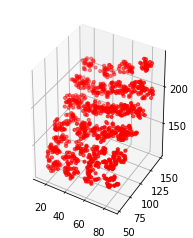

In [13]:
"""
Generate a test set by taking every point in the training set and for each of these 40 points 
generate 25 new points that are randomly placed in a sphere with radius "radius" from the initial point. 
Each new point has the same class as the original point. 
This will give us a test set with 1000 points - 500 "-" points and 500 "+" points.
"""

def sample_spherical(center,radius,npoints):
    n=0
    xl = []
    yl = []
    zl = []
    while (n<npoints):
        x = np.random.uniform(-radius, radius)
        y = np.random.uniform(-radius, radius)
        z = np.random.uniform(-radius, radius)
        while (sqrt((x*x)+(y*y)+(z*z)) > radius):
            x = np.random.uniform(-radius, radius)
            y = np.random.uniform(-radius, radius)
            z = np.random.uniform(-radius, radius)
#         print(n)
#         print(x,y,z)
        xl.append(x + center[0])
        yl.append(y + center[1])
        zl.append(z + center[2])
        n+=1
    return xl,yl,zl
    

radius = 8
npoints= 25

training_set = load_dataset('bmiv2.csv')
display(training_set.head())
test_set = {'f1':[], 'f2': [], 'f3':[], 'class':[]}

for index, row in training_set.iterrows():
    x,y,z = sample_spherical(center=[row['f1'],row['f2'],row['f3']], radius=radius, npoints=npoints)
    test_set['f1'].extend(x)
    test_set['f2'].extend(y)
    test_set['f3'].extend(z)
    cl = [row['class']]*npoints
    test_set['class'].extend(cl)
    
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.scatter(test_set['f1'], test_set['f2'], test_set['f3'], s=10, c='r', zorder=10)
test_set_df = pd.DataFrame.from_dict(test_set)
display(test_set_df.head())
test_set_df.to_csv('../../datasets/test_bmiv2_8.csv', index=False)


In [14]:
# Simulation: Testing
# Need to do the same rotations that we did for training, and keep track of it. 


def testing(dataset, test_dataset):
    """
    Testing initial accuracy on test dataset based on SVM from training dataset
    """
    print("Testing")
    training = dataset
#     testing_dataset = testing_dataset.round({'f1': 0, 'f2': 0, 'f3':0})
#     display(testing_dataset.head())
#     display(training.head())

    clf = get_clf()
    clf.fit(training.iloc[:,:3], training['class'])
    
    #Training
    y_pred_train = clf.predict(training.iloc[:,:3])
    y_true_train = training['class'].values
#     print("Prediction on train data" , y_pred_train)
#     print("True class of train data", y_true_train)
#     print("ACCURACY TRAIN: ", accuracy_score(y_true_train, y_pred_train))
    
    #Testing
    y_pred_test = clf.predict(test_dataset.iloc[:,:3])
    y_true_test = test_dataset['class'].values
#     print("Prediction on test data" , y_pred_test)
#     print("True class of test data", y_true_test)
    print("ACCURACY TEST: ", accuracy_score(y_true_test, y_pred_test))
    
    

dataset = load_dataset('bmi.csv')
test_dataset = pd.read_csv('../../datasets/test_bmiv2_8.csv')
testing(dataset,test_dataset)

    
    

Testing
Prediction on train data [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1
 1 1 1]
True class of train data [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1
 1 1 1]
ACCURACY TRAIN:  1.0
Prediction on test data [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [31]:
# Simulation: Training. 

def training(dataset, test_dataset, iterations):
    """
    Training SVM on dataset
    When removing the extra SV, we pass a new dataset without the extra SV to a new clf, that is the output
    of the remove_extra_sv function. 
    X and Y remain the same
    """
    print("\nStarting training")
    # Dictionary that saves the information of every rotation
    folding_info = dict()
    
    # Data
    angle, part_folded, x_folded, y_folded, prime_sv, f_point = None, None, None, None, None, None
    should_plot = True
    Y = dataset['class']
    
    for i in range(0,iterations): 
        print("ITERATION ", i+1)
#         print("DEBUG: TEST DATASET INITIAL FOR: " )
#         display(test_dataset)
        # 0. Check N SVs:
        if get_nSV_3D(dataset)<3:
            print("Training is over. Number of SVs is: ",get_nSV_3D(dataset))
            break
        
        # 1. Rotation: Translating 3D to 2D
        X_rotated, Z, X_test_rot, Z_test = rotate_points(dataset, test_dataset)
        X = X_rotated
#         print("X Test Rotated: ")
#         display(X_test_rot)
        
        # 2. SVM, margin and plot of the initial points. 
        clf = get_clf() 
        clf.fit(X, Y)
        margin = get_margin(clf)
        print("Initial Plot")
        plot_SVM(clf,np.array(X), np.array(Y), should_plot)
        clf_init = clf

        # Remove extra support vectors only when needed. That is then the shape of the SVs is =!
        # from [2,1] or [1,2]
        if (clf.n_support_[0]==1 and clf.n_support_[1]==2) or (clf.n_support_[0]==2 and clf.n_support_[1]==1):
            print ("Training: No need to remove extra SVs")
        else:
#             print("Training: Removing extra SVs")
#             print("DEBUG: SV INDX before removing extra:\n", clf.support_)
            clf = remove_extra_sv(clf,X,Y)
            print("Plot after removing extra SVs")
            plot_SVM(clf, np.array(X), np.array(Y), should_plot)
#             print("DEBUG: SV INDX after removing extra:\n", clf.support_)

        if i==0:
            print("\nInitial SVM. No folding yet.  Initial Margin: {:f}".format(margin))
        else:
            print("Folding number: ", i+1)
#             print("DEBUG: SVs before folding, after removing extra SV :\n", clf.support_vectors_)
#             print("DEBUG: SV INDX before folding, after removing extra SV :\n", clf.support_)


        # 3. Folding. 
        Y_test = test_dataset['class']
        part_folded, X_folded, Y_folded, X_folded_test, Y_folded_test = folding(X, 
                                                                                Y, 
                                                                                X_test_rot, 
                                                                                Y_test,clf)

        # 4. SVM on the folded points, to check the margin increase. Plot it
        clf = get_clf() 
        clf.fit(X_folded, Y_folded)
        margin = get_margin(clf)
        print("Folding {:d} . Folding the {:s}. New margin: {:f}".format(i+1,part_folded, margin))
        plot_SVM(clf,np.array(X_folded), np.array(Y_folded), should_plot)
#         print("Training DATASET after folding.")
#         display(pd.concat([X_folded, Y_folded], axis=1))
#         print("Test dataset after folding (No Z component)")
#         display(pd.concat([X_folded_test, Y_folded_test], axis=1))
            
        # 5. Add the Z component. 
        dataset_after_folding = pd.concat([X_folded, Z,  Y_folded], axis=1)
#         print("Training DATASET after folding. Adding Z component")
#         display(dataset_after_folding)
        dataset=dataset_after_folding
        Y = dataset_after_folding['class']
        
        # 6. Testing accuracy
        test_dataset = pd.concat([X_folded_test, Z_test, Y_folded_test], axis=1)
#         print("Test DATASET after rotation and folding")
#         display(test_dataset)
        acc = get_accuracy (dataset, test_dataset)
        print("Accuracy of folded test set on SVM obtained from folded training set. 3D:  ", acc)



Starting training
ITERATION  1
Rotation
Number of SVs 4 
SV index:  [20 24  7 36]
Initial Plot


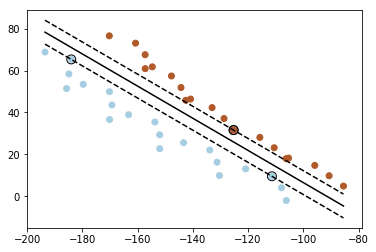

Plot after removing extra SVs


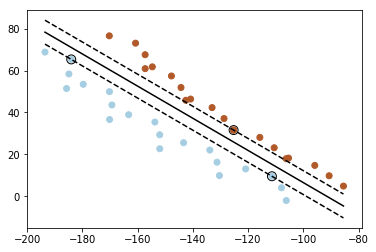


Initial SVM. No folding yet.  Initial Margin: 9.037809

SVM Set 1: LEFT


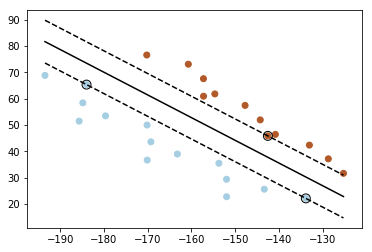


SVM Set 2: RIGHT


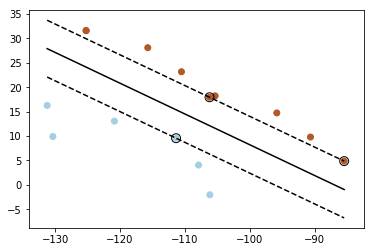

Folding SET1
Folding 1 . Folding the left. New margin: 9.844276


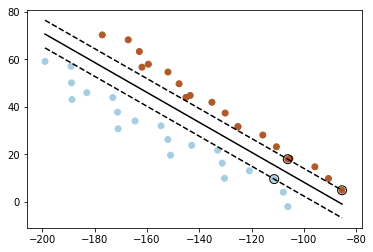

Accuracy of folded test set on SVM obtained from folded training set. 3D:   0.986
ITERATION  2
Rotation
Number of SVs 4 
SV index:  [20  6 35 37]
Initial Plot


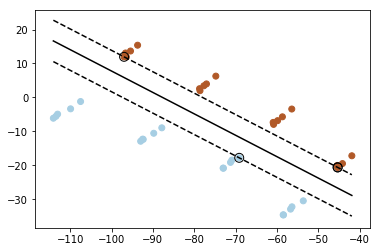

Plot after removing extra SVs


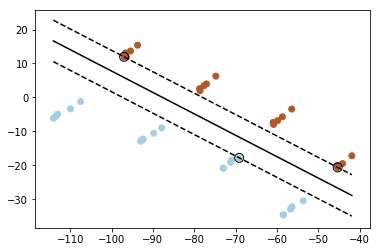

Folding number:  2

SVM Set 1: LEFT


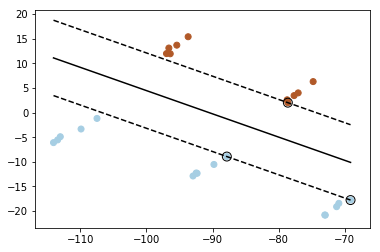


SVM Set 2: RIGHT


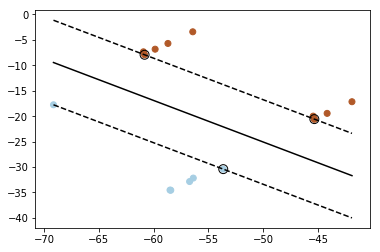

Folding SET1
Folding 2 . Folding the left. New margin: 12.875876


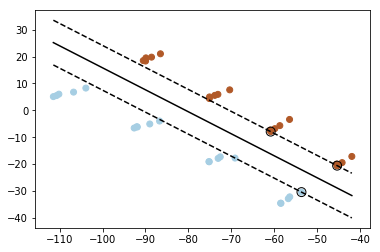

Accuracy of folded test set on SVM obtained from folded training set. 3D:   0.996
ITERATION  3
Rotation
Number of SVs 5 
SV index:  [20 30 25 35 37]
Initial Plot


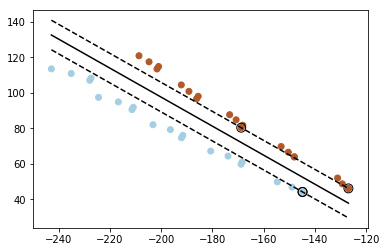

Plot after removing extra SVs


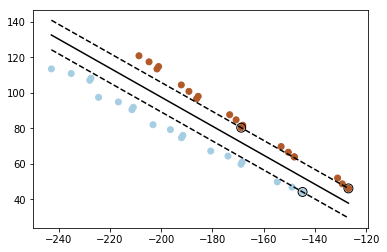

Folding number:  3

SVM Set 1: LEFT


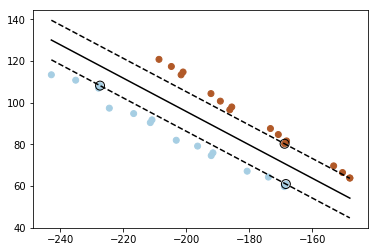


SVM Set 2: RIGHT


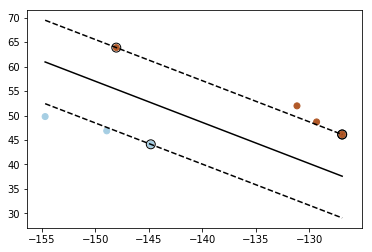

Folding SET1
Folding 3 . Folding the left. New margin: 13.050901


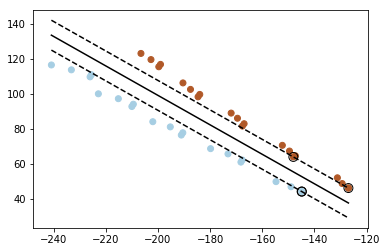

Accuracy of folded test set on SVM obtained from folded training set. 3D:   0.996


In [32]:
"""
Hyperplane folding - a way to increase the margin in Support Vector Machines
3D case for hyperplane folding

1. Rotation. Transform to 2D
2. Folding like 2D
3. Testing while rotating and folding
"""


# Import necessary packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn import svm
from sklearn.metrics import accuracy_score
import math
import pandas as pd
from sklearn import datasets
from random import randint
from matplotlib.backends.backend_pdf import PdfPages
import time
from pylab import *
from sympy import *
from IPython.display import display, HTML
from collections import Counter

def main():
    iterations=3
    
    # Dataset
    dataset = load_dataset('bmiv2.csv')
    Y = dataset['class']
#     print("Initial Dataset ")
#     display(dataset)
    test_dataset = pd.read_csv('../../datasets/test_bmiv2_8.csv')


    # Training 
    training(dataset, test_dataset, iterations)

    # Testing 
#     print("Testing: Original accuracy")
#     testing(dataset,test_dataset)

    
if __name__ =='__main__':
    main()